In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import our models. The package will take care of downloading the models automatically

model_id = "princeton-nlp/unsup-simcse-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained("/workspace/model").to(device)

/workspace/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('/workspace/harry_potter_1.txt', 'r') as f:
    text = f.read()

In [3]:
tokenized_text = tokenizer(text, return_tensors="pt")["input_ids"][0].to(device)

Token indices sequence length is longer than the specified maximum sequence length for this model (116727 > 512). Running this sequence through the model will result in indexing errors


In [41]:
stack_size = 32
input_ids = torch.zeros(stack_size, 128, dtype=torch.long).to(device)

for i in range(stack_size):
    input_ids[i] = tokenized_text[i*64:(i+2)*64]

with torch.no_grad():
    embeddings = model(input_ids).last_hidden_state

embeddings.shape

torch.Size([32, 128, 1024])

In [42]:
output = torch.zeros((stack_size + 1) * 64, 1024)
output[0:64] = embeddings[0, 0:64]

for i in range(stack_size):
    output[(i+1)*64:(i+2)*64] = embeddings[i, 64:128]

output.shape

torch.Size([2112, 1024])

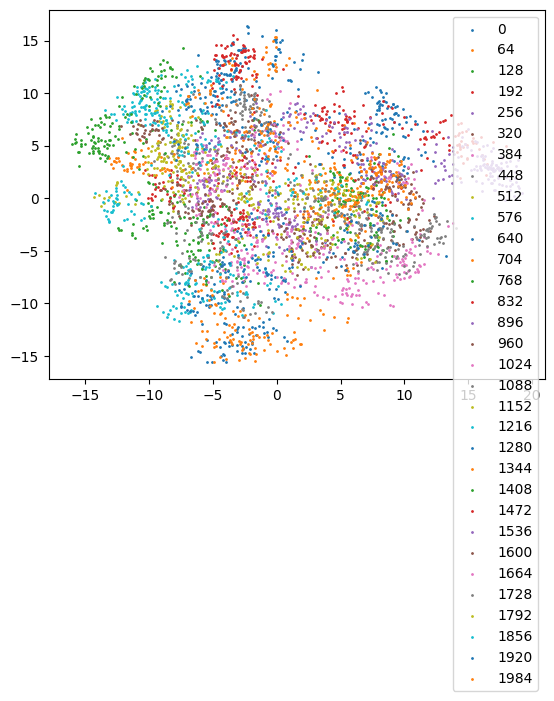

: 

In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

pca.fit(output.cpu().numpy())

for i in range(32):
    embedding = pca.transform(embeddings[i].cpu().numpy())

    plt.scatter(embedding[:, 0], embedding[:, 1], s=1, label=i * 64)

plt.legend()
plt.show()

In [44]:
text1="""
Once in a magical forest, there lived a tiny fairy named Luna. She had iridescent wings that shimmered in the moonlight. Every night, Luna would dance across the forest, spreading stardust that turned leaves into silver and flowers into crystals. One evening, she stumbled upon a lost, timid hedgehog. Seeing its sadness, Luna used her magic to create a pathway of glowing mushrooms, leading the hedgehog back to its family. Overwhelmed with joy, the hedgehog's family granted Luna a crown made of the finest autumn leaves, symbolizing the eternal friendship between the fairy and the creatures of the forest. And so, Luna became not just a guardian of nature, but a beloved friend to all in her enchanted realm."""

text2="""
In the depths of a sprawling metropolis, there was a figure cloaked in mystery and darkness, known only as Raven. Raven was a merciless assassin, renowned for his precision and ruthlessness. He moved like a shadow, leaving a trail of silence in his wake. His latest mission was personal, targeting a crime lord who had wronged him in the past. Raven infiltrated the heavily guarded fortress with stealth and agility, neutralizing threats with cold efficiency. As he confronted his nemesis, a fierce battle ensued, echoing through the night. In the end, Raven stood victorious, his enemy defeated at his feet. He vanished into the night, leaving behind a legend that would be whispered in fear and awe for generations to come."""

text3="""
The tiny fairy Luna whos beautifuly helped saved a hedgedog from the forest."""

In [45]:
input_ids = torch.zeros((3, 128), dtype=torch.long).to(device)
token_masks = torch.zeros((3, 128), dtype=torch.long).to(device)

for i, text in enumerate([text1, text2, text3]):
    tokenized_text = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    input_ids[i] = tokenized_text["input_ids"][0]
    token_masks[i] = tokenized_text["attention_mask"][0]

input_ids = input_ids.to(device)
token_masks = token_masks.to(device)

In [46]:
model.train()

with torch.no_grad():
    embeddings_1 = model(input_ids, token_masks).last_hidden_state
    embeddings_2 = model(input_ids, token_masks).last_hidden_state

    embeddings_1 = embeddings_1 / torch.norm(embeddings_1, dim=-1, keepdim=True)
    embeddings_2 = embeddings_2 / torch.norm(embeddings_2, dim=-1, keepdim=True)

    embeddings_1 = embeddings_1 * token_masks.unsqueeze(-1)
    embeddings_2 = embeddings_2 * token_masks.unsqueeze(-1)

    embeddings_1 = embeddings_1.reshape(-1, 1024)
    embeddings_2 = embeddings_2.reshape(-1, 1024)

    similarity = torch.mm(embeddings_1, embeddings_2.T)
    similarity = similarity.reshape(3, 128, 3, 128).transpose(1, 2)

    # similarity = torch.exp(similarity / 0.05)

    # similarity = torch.sum(similarity, dim=(1, 3)) / torch.sum(token_masks, dim=-1)

    # chosen_sim= torch.diagonal(similarity)
    # sum_sim = torch.sum(similarity, dim=-1)

    # loss = -torch.log(chosen_sim / sum_sim)
    # print(loss)

In [47]:
similarity

tensor([[[[ 9.4634e-01,  7.5897e-01,  4.3642e-01,  ..., -6.1371e-02,
            3.1999e-02,  2.9464e-02],
          [ 7.0743e-01,  8.8379e-01,  4.2642e-01,  ..., -2.4101e-04,
            8.4524e-02,  8.0267e-02],
          [ 4.2297e-01,  4.1457e-01,  8.3273e-01,  ...,  6.3241e-02,
            9.1411e-02,  9.7508e-02],
          ...,
          [-1.0448e-01, -4.8988e-02,  1.3563e-02,  ...,  8.7518e-01,
            7.1712e-01,  7.7330e-01],
          [-8.1420e-03,  3.7853e-02,  5.7745e-02,  ...,  7.2879e-01,
            9.0439e-01,  8.3511e-01],
          [ 3.8109e-03,  5.0320e-02,  6.5030e-02,  ...,  7.7286e-01,
            8.1063e-01,  8.9706e-01]],

         [[ 9.4417e-01,  7.0507e-01,  4.7805e-01,  ..., -1.7656e-01,
           -1.3879e-02, -1.6324e-01],
          [ 7.0781e-01,  8.9955e-01,  5.2466e-01,  ..., -1.8602e-01,
           -3.4864e-02, -1.5008e-01],
          [ 4.1689e-01,  4.0461e-01,  2.3638e-01,  ..., -1.1061e-03,
            1.2822e-02, -5.7766e-02],
          ...,
     

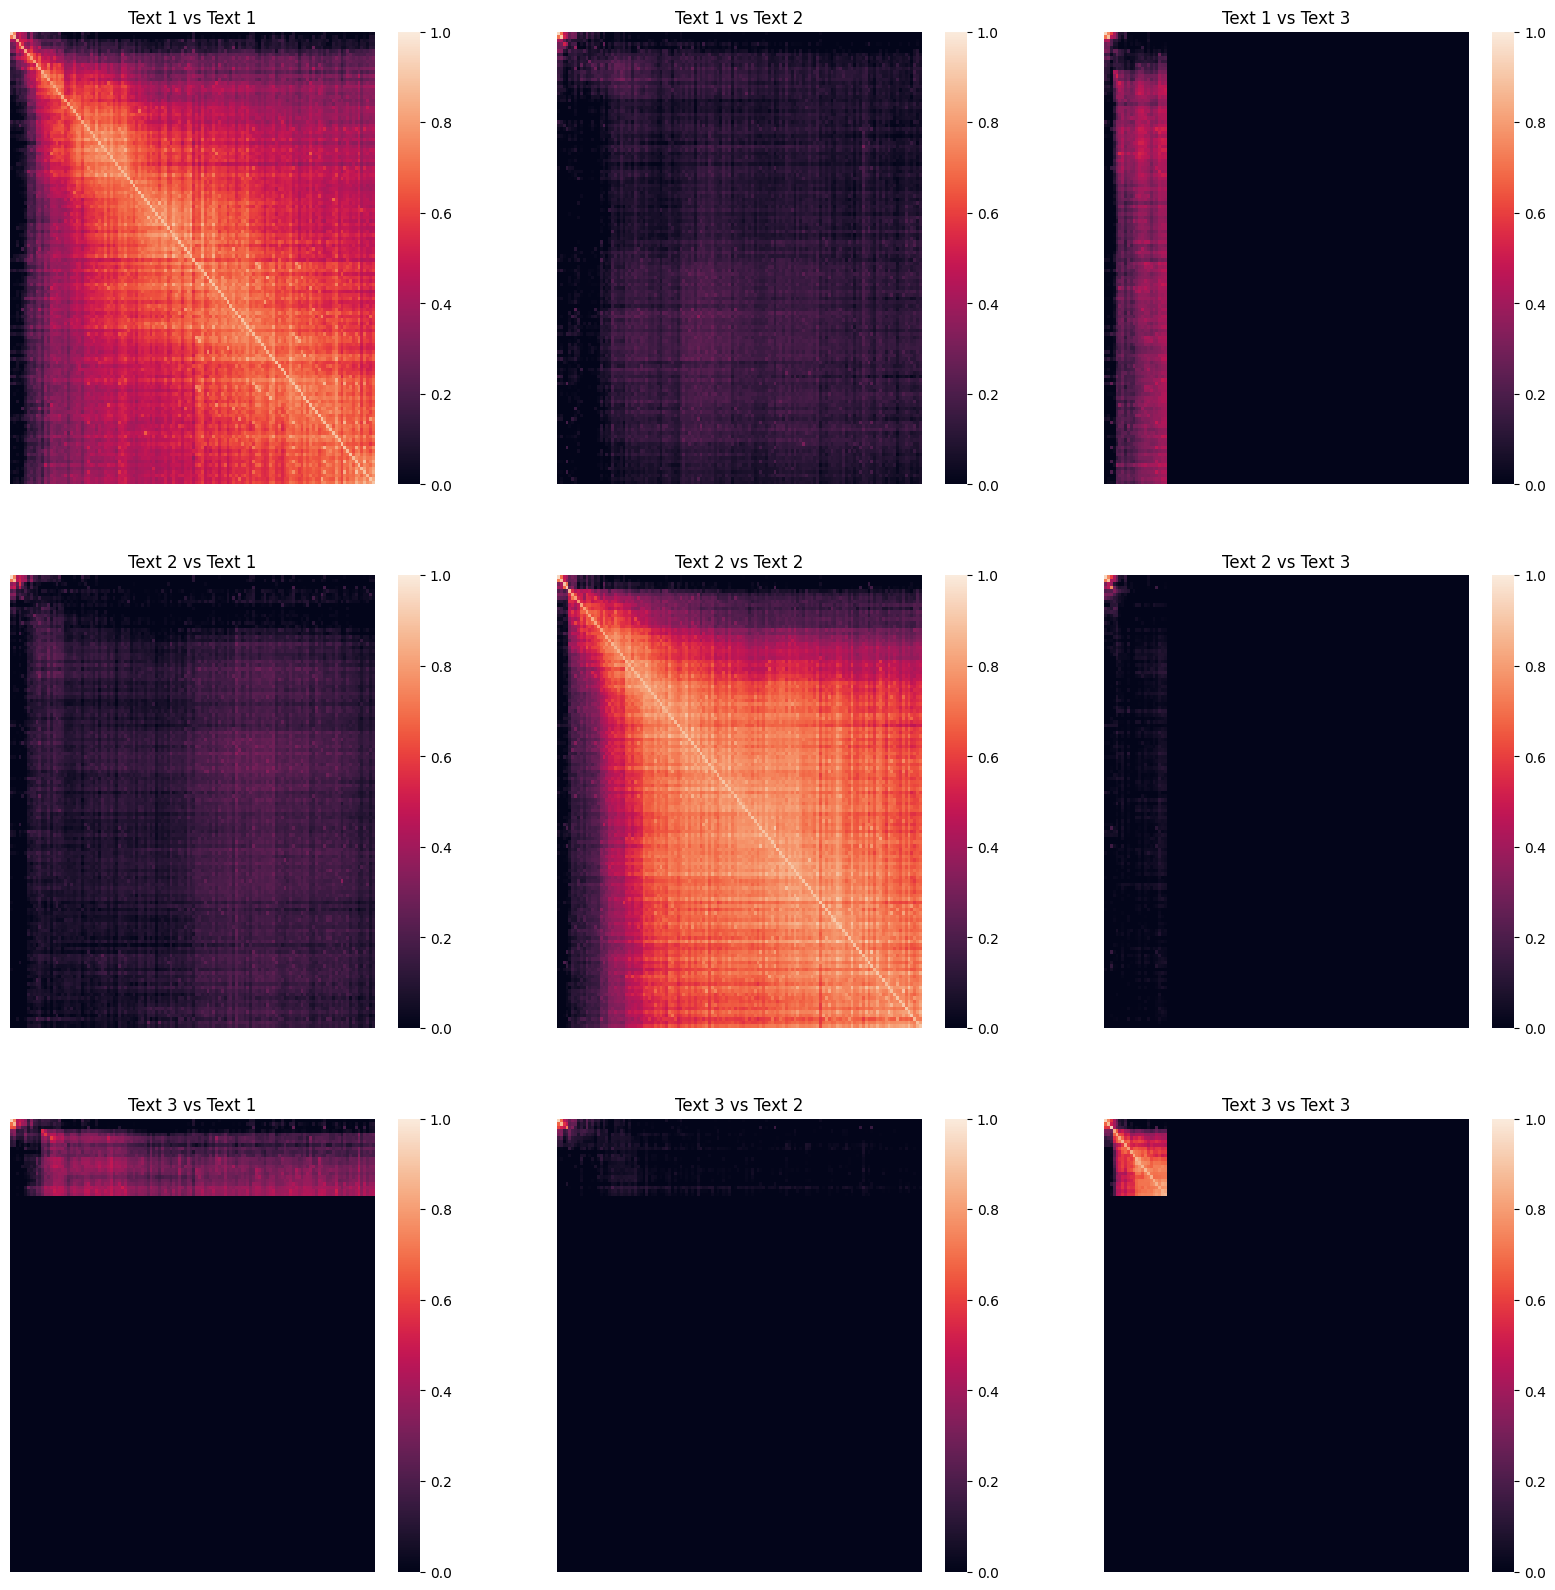

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for i in range(3):
    for j in range(3):
        sns.heatmap(similarity[i, j].cpu().numpy(), ax=ax[i, j], vmin=0, vmax=1)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f"Text {i+1} vs Text {j+1}")

In [49]:
# download snli dataset
from torch.nn import CosineSimilarity
from scipy.stats import spearmanr
from datasets import load_dataset

BATCH_SIZE=32
VALIDATION_SIZE=10
MAX_LEN=128

dataset = load_dataset("stsb_multi_mt", 'en', split="test").with_format(
    "torch", device=device)

def prepare_validation_set(dataset, max_size=VALIDATION_SIZE):
    batch = []
    for i in range(max_size * BATCH_SIZE):
        data = dataset[i]
        premise = tokenizer(data['sentence1'], padding='max_length', truncation=True,
                            return_tensors='pt', max_length=MAX_LEN)
        hypothesis = tokenizer(data['sentence2'], padding='max_length', truncation=True,
                               return_tensors='pt', max_length=MAX_LEN)
        batch.append((premise, hypothesis, data['similarity_score']))

        if len(batch) == BATCH_SIZE:
            token_ids = torch.zeros(2, BATCH_SIZE, MAX_LEN, dtype=torch.long)
            token_masks = torch.zeros(2, BATCH_SIZE, MAX_LEN, dtype=torch.long)
            scores = torch.zeros(BATCH_SIZE, dtype=torch.float)

            for i, (premise, hypothesis, score) in enumerate(batch):
                token_ids[0, i] = premise['input_ids']
                token_ids[1, i] = hypothesis['input_ids']

                token_masks[0, i] = premise['attention_mask']
                token_masks[1, i] = hypothesis['attention_mask']

                scores[i] = score

            yield token_ids, token_masks, scores
            batch = []
validation_set = list(prepare_validation_set(dataset))

In [50]:
def validate(model, step=0, log=True):
    model.eval()
    with torch.no_grad():
        predicated_scores = []
        actual_scores = []
        for batch in validation_set:
            token_ids, token_masks, scores = batch
            token_ids = token_ids.to(device)
            token_masks = token_masks.to(device)
            scores = scores.to(device)

            sentence1_outputs = model(
                input_ids=token_ids[0], attention_mask=token_masks[0]).last_hidden_state

            sentence2_outputs = model(
                input_ids=token_ids[1], attention_mask=token_masks[1]).last_hidden_state

            sentence1_outputs = sentence1_outputs / torch.norm(
                sentence1_outputs, dim=-1, keepdim=True)

            sentence2_outputs = sentence2_outputs / torch.norm(
                sentence2_outputs, dim=-1, keepdim=True)


            sentence1_outputs = sentence1_outputs * (token_masks[0].unsqueeze(-1))
            sentence2_outputs = sentence2_outputs * (token_masks[1].unsqueeze(-1))

            batch_similarity = torch.bmm(sentence1_outputs, sentence2_outputs.transpose(1, 2))
            # batch_similarity = torch.exp(batch_similarity / 0.05)
            # batch_similarity = torch.sum(batch_similarity, dim=(1, 2)) / torch.sum(token_masks[0], dim=-1) / torch.sum(token_masks[1], dim=-1)
            i = 2

            print(batch_similarity[i, :7, :7])
            print(dataset['sentence1'][i])
            print(dataset['sentence2'][i])
            print(scores[i].item())
            return

            # predicated_scores.extend(batch_similarity.cpu().numpy())
            # actual_scores.extend(scores.cpu().numpy())
            # return

        rank= spearmanr(predicated_scores, actual_scores)

    return rank.correlation
validate(model)

tensor([[1.0000, 0.3995, 0.0713, 0.1471, 0.0614, 0.0412, 0.1031],
        [0.5007, 0.4713, 0.1612, 0.1209, 0.1830, 0.1631, 0.1727],
        [0.0415, 0.0783, 0.8141, 0.4285, 0.5759, 0.7391, 0.6089],
        [0.0973, 0.1263, 0.6479, 0.4552, 0.5751, 0.6118, 0.6569],
        [0.0890, 0.0461, 0.5121, 0.6127, 0.6295, 0.6369, 0.6525],
        [0.0168, 0.0419, 0.5427, 0.5733, 0.8059, 0.7151, 0.7198],
        [0.0041, 0.0690, 0.7047, 0.5444, 0.6878, 0.8465, 0.7053]],
       device='cuda:0')
One woman is measuring another woman's ankle.
A woman measures another woman's ankle.
5.0
